<a href="https://www.kaggle.com/code/jhendi/shop-customer-cluster-and-prediction?scriptVersionId=139460963" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customers-dataset/Customers.csv


# Load Libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Clustering Models
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.manifold import TSNE

# Classification models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **Data Loading**

In [3]:
df = pd.read_csv("/kaggle/input/customers-dataset/Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              2000 non-null   int64 
 1   Gender                  2000 non-null   object
 2   Age                     2000 non-null   int64 
 3   Annual Income ($)       2000 non-null   int64 
 4   Spending Score (1-100)  2000 non-null   int64 
 5   Profession              1965 non-null   object
 6   Work Experience         2000 non-null   int64 
 7   Family Size             2000 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 125.1+ KB


There are **35** missing records in professional. I'm going to see what the types of unique professions there are

In [5]:
#setting customerID as index
df.set_index('CustomerID', inplace=True)

In [6]:
df['Profession'].unique()

array(['Healthcare', 'Engineer', 'Lawyer', 'Entertainment', 'Artist',
       'Executive', 'Doctor', 'Homemaker', 'Marketing', nan], dtype=object)

In [7]:
df[df['Profession'].isna()]

,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
CustomerID,,,,,,,
80,Female,49,98000,42,NaN,1,1
119,Female,51,84000,43,NaN,2,7
220,Female,59,76000,61,NaN,9,1
238,Male,95,36000,35,NaN,0,4
438,Male,76,136259,14,NaN,0,7
441,Female,0,57373,29,NaN,0,7
499,Male,95,121725,3,NaN,12,3
546,Female,89,107359,26,NaN,10,6
602,Male,61,126370,20,NaN,11,4


The values across the other features are wide, so I'm going to categorize the NaN values as 'Other'.

In [8]:
df['Profession'].fillna('Unknown', inplace=True)

In [9]:
df.describe()

,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,48.960000,110731.821500,50.962500,4.102500,3.768500
std,28.429747,45739.536688,27.934661,3.922204,1.970749
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,25.000000,74572.000000,28.000000,1.000000,2.000000
50%,48.000000,110045.000000,50.000000,3.000000,4.000000
75%,73.000000,149092.750000,75.000000,7.000000,5.000000
max,99.000000,189974.000000,100.000000,17.000000,9.000000


Based on the summary stats above, a few things that look weird. 
* First is Age min is 0 and max is 99 
* Annual income that is at 0. They might be volunteers but still that looks weird. 
* Spend score of 100, meaning that the person spends the entirety of their salary. 
* Family size 9 seems too large. Each one must be examined.

In [10]:
df[df['Family Size'] == 9]

,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
CustomerID,,,,,,,
151,Male,43,30000,17,Lawyer,0,9


CustomerID 151 is a 43 year old male with an annual income of $30k, a very low spend score, a lawyer with 0 work experience and a family size of 9. With his family size and annual income the spend score makes sense. As for work experience that needs to be assumed that he could be transitioning into law or a missed entry.

In [11]:
df[df['Annual Income ($)'] == 0]

,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
CustomerID,,,,,,,
170,Male,32,0,63,Artist,2,2
247,Male,23,0,96,Doctor,1,3


This might be a mis-entry. Both professions make over 100k on average. (see chart below)

In [12]:
df[df['Age'] == 99]

,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
CustomerID,,,,,,,
348,Female,99,184426,41,Artist,9,1
352,Male,99,173394,4,Engineer,13,1
362,Male,99,63364,61,Entertainment,1,2
547,Male,99,164781,83,Engineer,0,2
568,Female,99,172896,13,Engineer,0,3
938,Female,99,56851,72,Entertainment,6,3
1017,Female,99,55972,83,Entertainment,1,7
1020,Female,99,145777,94,Executive,1,5
1104,Female,99,103706,50,Entertainment,1,2


This is weird because work experiences are relatively low but the annual income is over 100k? Assuming the only thing incorrect is the age entry we can just impute the last age value based on income and profession. If work experience was correct we'd have to assume they just entered a newly high paying job through a promotion or through a career transition.

In [13]:
df[df['Age'] == 0]

,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
CustomerID,,,,,,,
212,Female,0,22000,92,Artist,2,1
229,Male,0,33000,64,Marketing,1,1
334,Male,0,173743,96,Artist,0,4
441,Female,0,57373,29,Unknown,0,7
444,Female,0,68761,16,Lawyer,1,4
467,Male,0,186002,80,Doctor,15,2
560,Male,0,151298,89,Artist,0,6
563,Female,0,142892,25,Entertainment,8,1
768,Female,0,143910,22,Marketing,1,7


Similar to the above, records with min age 0 means means they're just born, which is incorrect. We'd have to assume that the average minimum age of workforce entry for the give professions are at least 22 since the professions listed need at least a bachelor's degree

In [14]:
df[df['Spending Score (1-100)'] == 100]

,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
CustomerID,,,,,,,
301,Male,85,153787,100,Entertainment,3,3
313,Female,24,118302,100,Lawyer,5,1
323,Female,89,110667,100,Healthcare,2,4
565,Female,51,141416,100,Healthcare,15,1
671,Male,54,59163,100,Marketing,3,3
681,Male,17,96154,100,Artist,1,4
708,Male,56,103210,100,Artist,6,6
824,Female,2,122698,100,Entertainment,8,1
907,Female,17,116463,100,Artist,8,4


It's important to note some of the records are weird, however I won't be imputing, removing, or making any changes to the records until we explore the data further. At this point it might be best for someone with domain expertise to give more insight on the data and how to best treat.

# Data Visualization

In [15]:
def piechart(x, y):

    # Group the DataFrame by 'x' (e.g., 'Gender' or 'Profession') and calculate the average income for each group
    group_data = df.groupby(x)[y].mean().reset_index()

    # Create a pie chart to visualize the distribution
    plt.figure(figsize=(6, 6))
    plt.pie(group_data[y], labels=group_data[x], autopct='%1.1f%%', startangle=140)
    plt.title("Average Income by {}".format(x))
    plt.axis('equal')

    # Display the pie chart
    plt.show()

    return

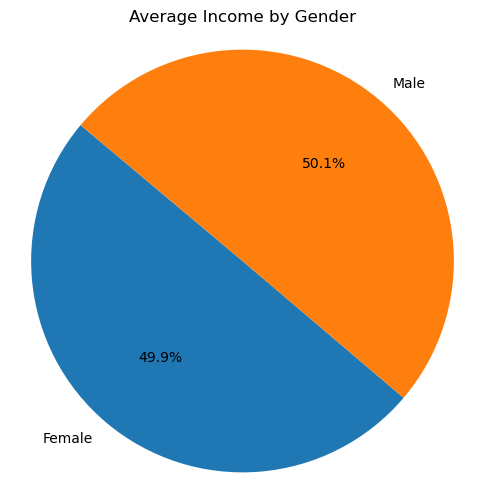

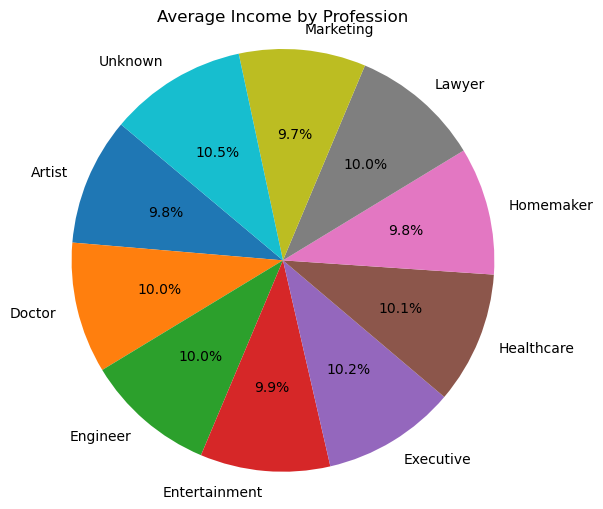

In [16]:
piechart('Gender', 'Annual Income ($)')
piechart('Profession', 'Annual Income ($)')

The data is pretty balanced between income for each gender and profession.

In [17]:
def box_plot(x, y):
    # Group the DataFrame by 'x' (e.g., 'Gender' or 'Profession') and get the income data for each group
    group_data = df.groupby(x)[y].apply(list).reset_index()

    # Create the box plot to visualize the distribution
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=x, y=y, data=df, palette='viridis')
    plt.title('{} by {}'.format(y, x))
    plt.xlabel(x)
    plt.ylabel('{}'.format(y))
    
    # Display the box plot
    plt.show()

    return

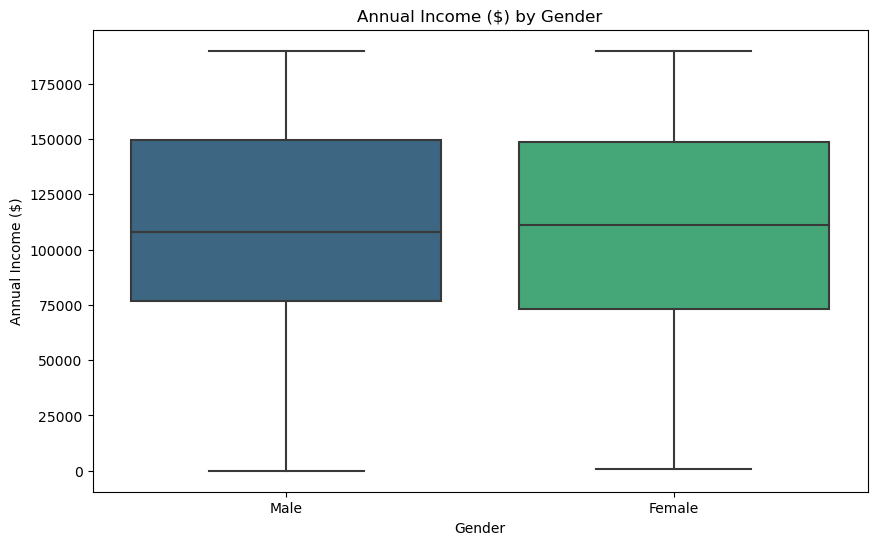

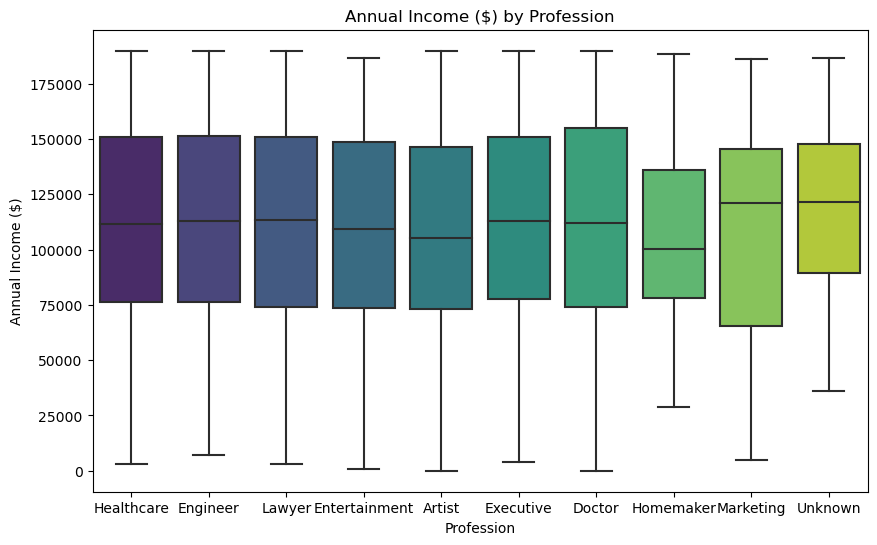

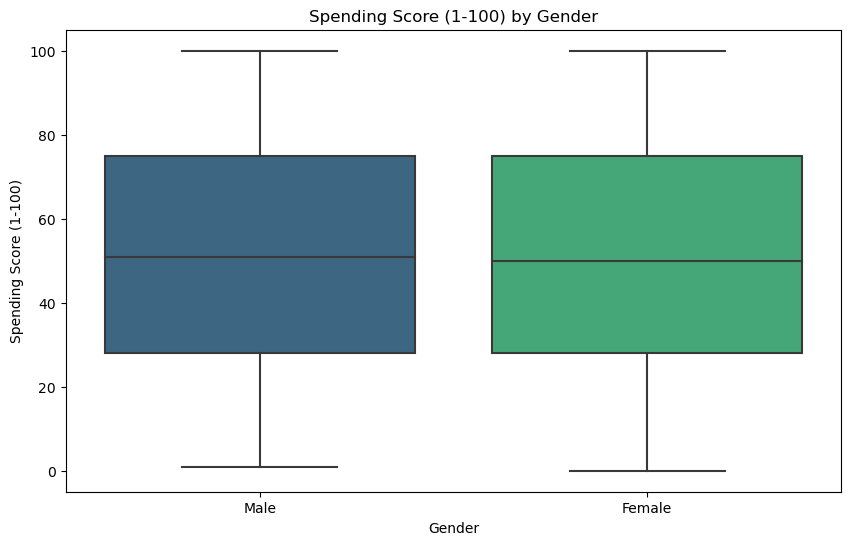

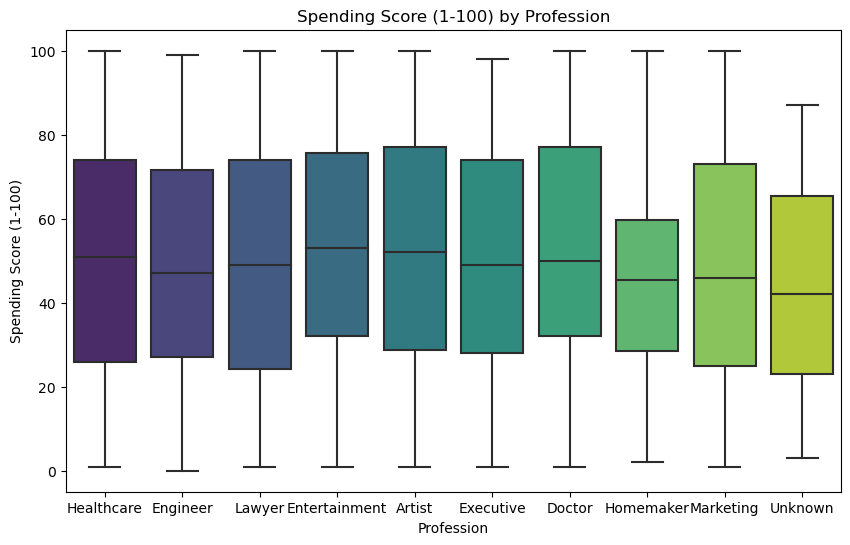

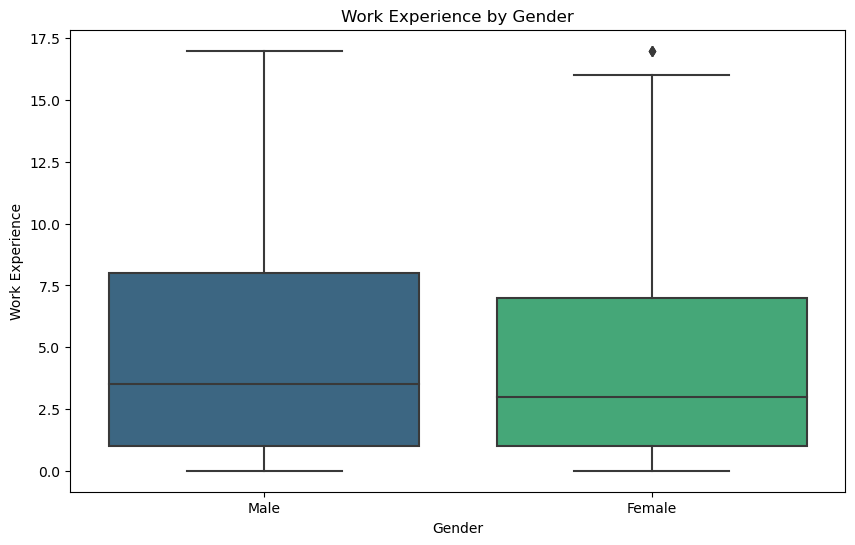

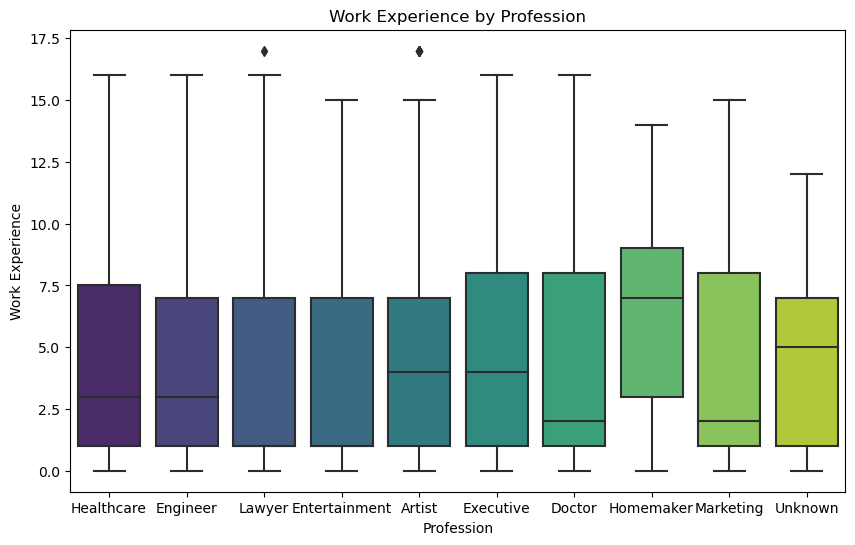

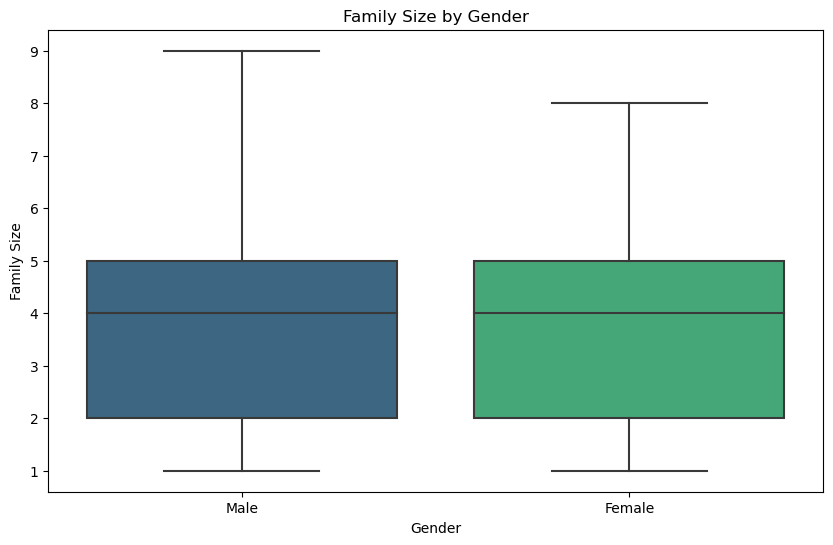

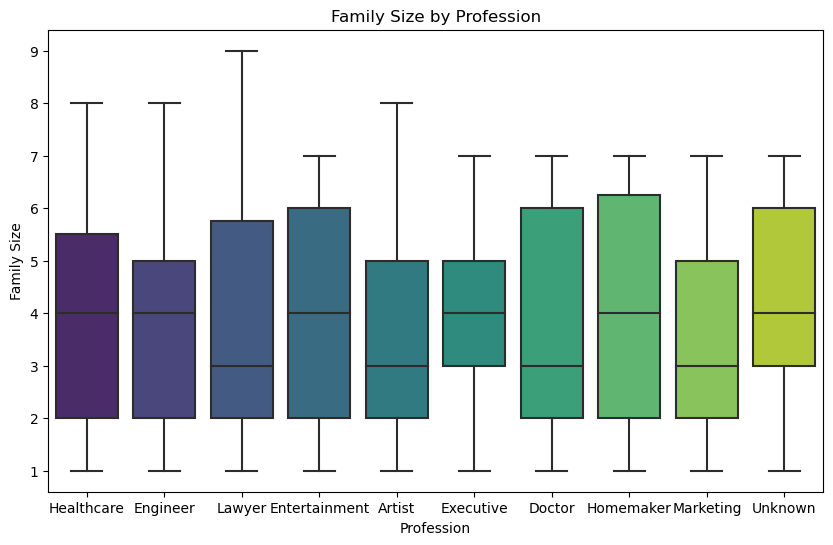

In [18]:
box_plot('Gender','Annual Income ($)')
box_plot('Profession','Annual Income ($)')
box_plot('Gender','Spending Score (1-100)')
box_plot('Profession','Spending Score (1-100)')
box_plot('Gender','Work Experience')
box_plot('Profession','Work Experience')
box_plot('Gender','Family Size')
box_plot('Profession','Family Size')

Overall, there isn't anything highly skewed or any imbalances. Theres also not a lot of outliers. Due to the size of the dataset I'm going to leave the outliers in the data since it won't affect much.

In [19]:
def scatter_plot(x,y):
    # Creating the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, data =df, color='blue', alpha=0.7)
    plt.title('{} vs. {}'.format(x,y))
    plt.xlabel('{}'.format(x))
    plt.ylabel('{}'.format(y))
    plt.grid(True)
    plt.show()
    
    return

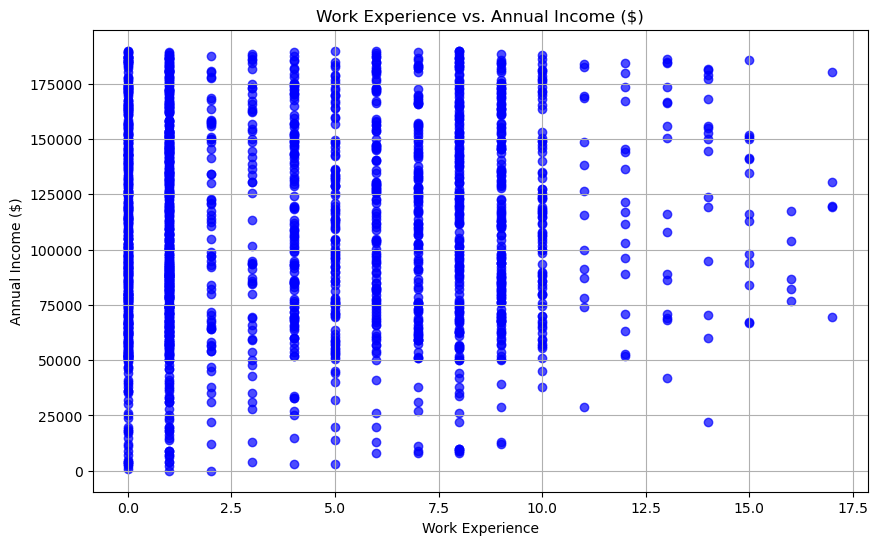

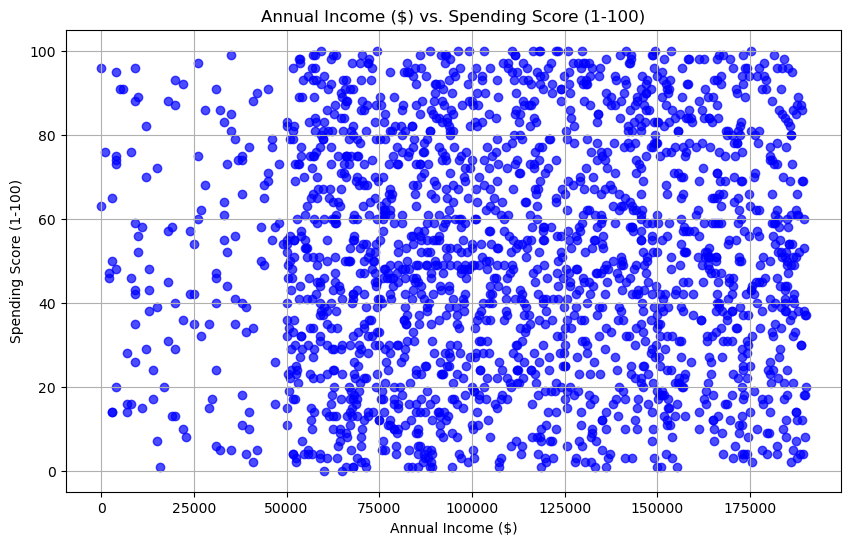

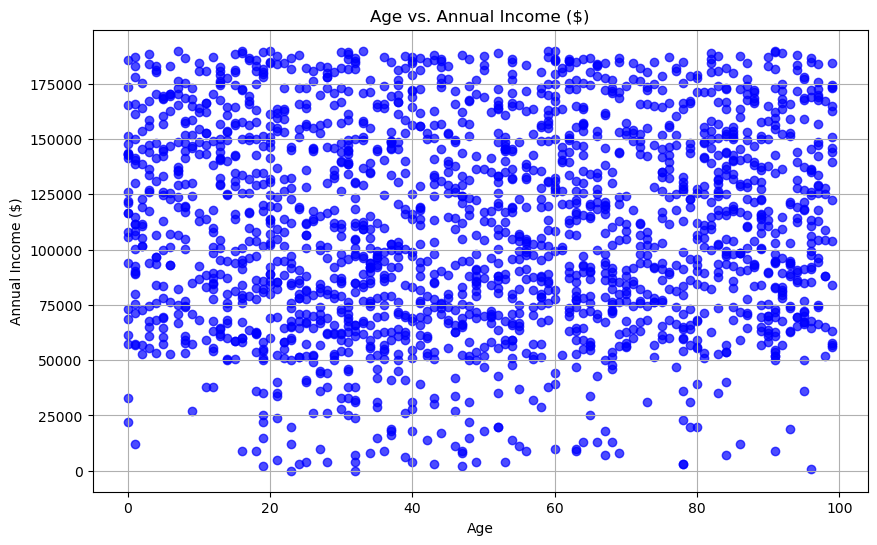

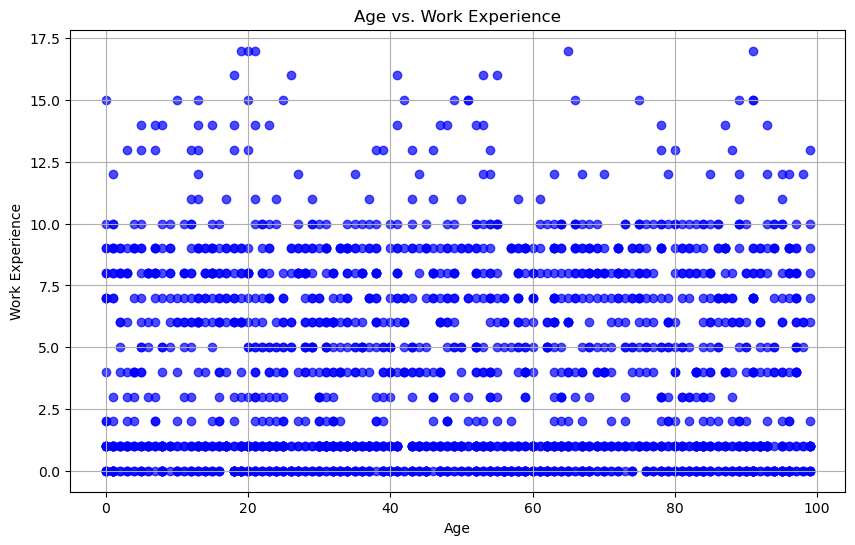

In [20]:
scatter_plot('Work Experience', 'Annual Income ($)')
scatter_plot('Annual Income ($)', 'Spending Score (1-100)')
scatter_plot('Age', 'Annual Income ($)')
scatter_plot('Age', 'Work Experience')

Features such as Age and Work Experience are very weird. There are records that show between ages 0-20 people have work experience of up to 17 years, meaning they started working since they were born. Similarly, work experience of <2 years some records show a salary upwards of almost $200k. 

/tmp/ipykernel_20/621126171.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


<Axes: >

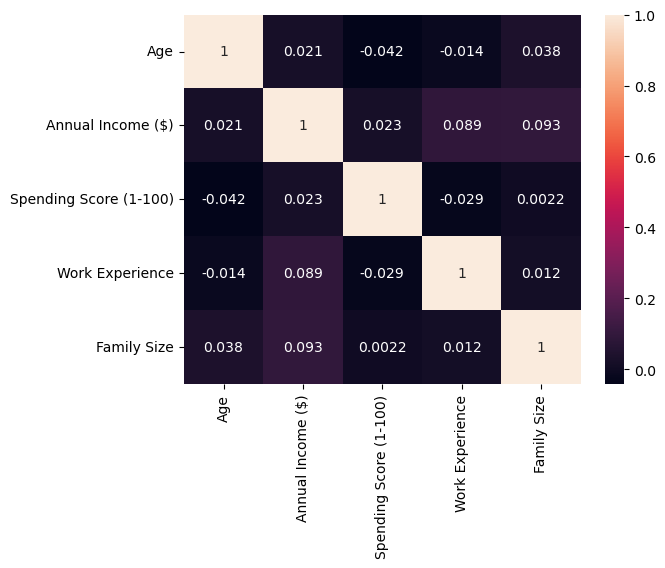

In [21]:
sns.heatmap(df.corr(), annot=True)

Due to the nature of the data, it makes sense there isn't a strong correlation amongst the features.

# Data Preprocessing

In [22]:
df.skew(numeric_only=True)

Age                       0.049222
Annual Income ($)        -0.116491
Spending Score (1-100)    0.004555
Work Experience           0.683718
Family Size               0.199263
dtype: float64

Work Experience is highly skewed

In [23]:
df['Work Experience'] = np.sqrt(df['Work Experience'])
df.skew(numeric_only=True)

Age                       0.049222
Annual Income ($)        -0.116491
Spending Score (1-100)    0.004555
Work Experience          -0.077357
Family Size               0.199263
dtype: float64

Convert categorical features into numerical using sklearn label encoder.

In [24]:
cat_col = ['Gender', 'Profession']

for cols in cat_col:
    # initialize encoder
    le = LabelEncoder()
    
    # transform features
    df[cols] = le.fit_transform(df[cols])

Applying a standard scaler to bring features to a standard scale.

In [25]:
# Rescale data using Standard Scaler for better clustering results
scaler = StandardScaler()
full_data = scaler.fit_transform(df)

# K-means cluster

Determine the amount of k-means clusters we'll be using

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

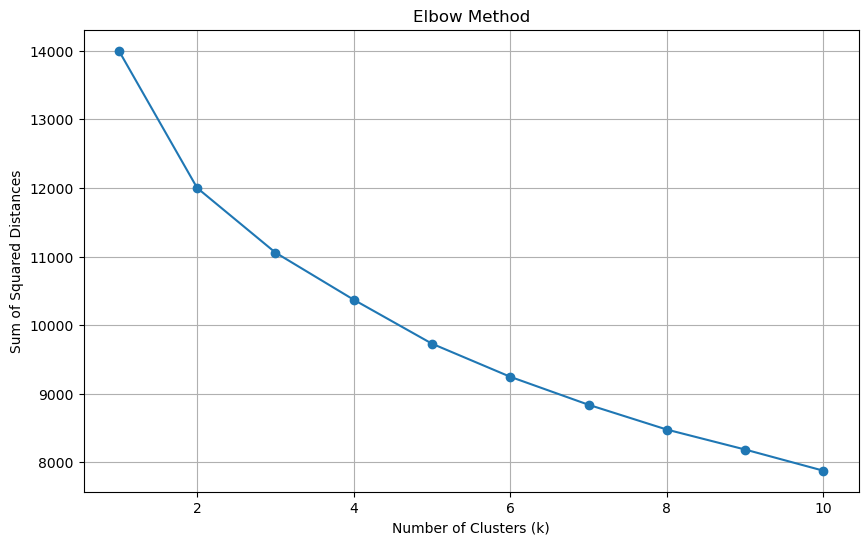

In [26]:
def elbow_chart(df):
    # create a list to store the sum of squared distances for each k
    ssd = []

    # fit KMeans clustering with different values of k
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(df)
        ssd.append(kmeans.inertia_)

    # create a dataframe with the k values and corresponding ssd
    df_ssd = pd.DataFrame({'k': range(1, 11), 'ssd': ssd})

    # create the line plot using matplotlib
    plt.figure(figsize=(10, 6))
    plt.plot(df_ssd['k'], df_ssd['ssd'], marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Sum of Squared Distances')
    plt.grid(True)
    plt.show()

    return

elbow_chart(full_data)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

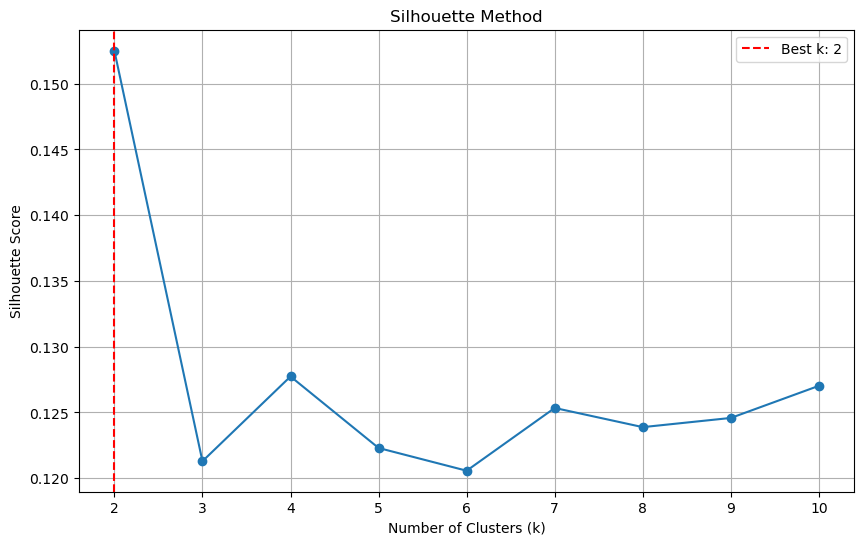

In [27]:
def silhouette_chart(df):
    # create a list to store the silhouette scores for each k
    silhouette_scores = []

    # fit KMeans clustering with different values of k
    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(df)
        silhouette_avg = silhouette_score(df, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)

    # find the k with the highest silhouette score
    best_k = np.argmax(silhouette_scores) + 2

    # plot the silhouette scores vs k
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, 11), silhouette_scores, marker='o')
    plt.title('Silhouette Method')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.axvline(x=best_k, linestyle='--', color='red', label=f'Best k: {best_k}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return

silhouette_chart(full_data)

tsne is used instead of PCA to fit the kmeans of each cluster because as we see above, the dataset isn't completely linear. Based on the scatterplots there isn't a clear linear direction which is why tsne would be better in this case.

In [28]:
tsne = TSNE(n_components=2, random_state=42)
df_tsne = tsne.fit_transform(full_data)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df_tsne)
pred = kmeans.predict(df_tsne)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


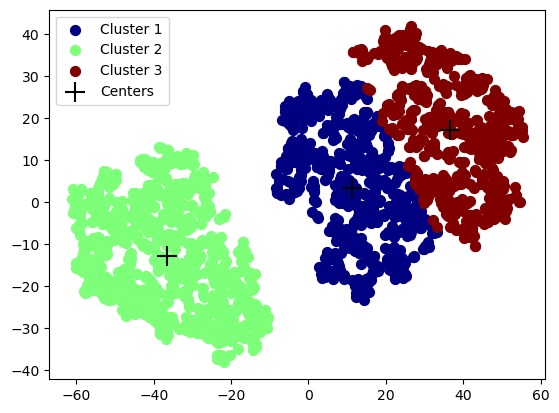

In [29]:
# Determine the number of unique clusters
unique_clusters = np.unique(pred)

# Generate a colormap and pick colors for each cluster
colors = plt.cm.jet(np.linspace(0, 1, len(unique_clusters)))

for i, color in enumerate(colors):
    plt.scatter(df_tsne[pred == i, 0], df_tsne[pred == i, 1], s=50, c=[color], label=f'Cluster {i+1}')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, marker='+', c='black', label='Centers')
plt.legend()
plt.show()

In [30]:
# Append cluster assignments to the dataframe
df['Cluster'] = pred

# Calculate mean values for each feature by cluster
cluster_means = df.groupby('Cluster').mean()
cluster_medians = df.groupby('Cluster').median()

print(cluster_means)
print(cluster_medians)

         Gender        Age  Annual Income ($)  Spending Score (1-100)  \
Cluster                                                                 
0           0.0  44.135843      113293.104746               48.186579   
1           1.0  49.159705      110991.323096               50.944717   
2           0.0  53.803478      107642.815652               53.937391   

         Profession  Work Experience  Family Size  
Cluster                                            
0          4.770867         1.381692     4.083470  
1          2.966830         1.676899     3.769042  
2          0.951304         1.928587     3.433043  
         Gender   Age  Annual Income ($)  Spending Score (1-100)  Profession  \
Cluster                                                                        
0           0.0  41.0           113575.0                    48.0         5.0   
1           1.0  48.0           108055.0                    51.0         3.0   
2           0.0  57.0           108544.0              

In [31]:
# Features and target
X = df.drop('Cluster', axis=1) 
y = df['Cluster']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)


Accuracy: 96.75%
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       109
           1       1.00      1.00      1.00       158
           2       0.95      0.95      0.95       133

    accuracy                           0.97       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.97      0.97      0.97       400



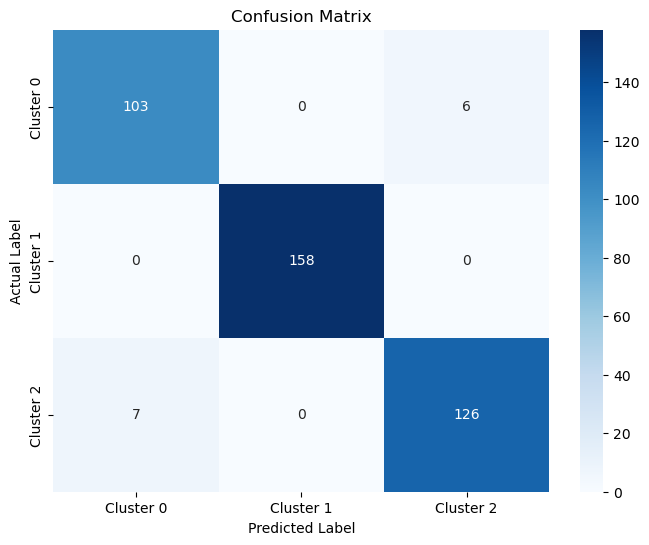

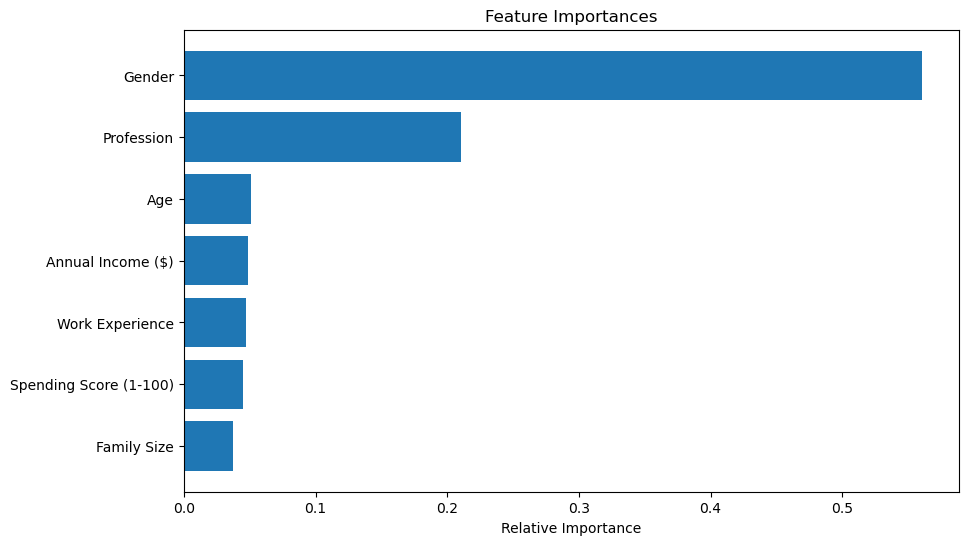

In [32]:

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Determine unique labels
unique_labels = sorted(np.unique(np.concatenate([y_test, y_pred])))
label_names = [f'Cluster {label}' for label in unique_labels]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Feature Importances
features = X.columns
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()